# Barbell Exercise Classifier

### Objective
- Build Model that can classify the barbell exercise using the time series data.

### About the data
- The data is collected using Meta Motion sensor.
- Time series data with accelerometer and gyroscope information.

### Data Source
- https://docs.datalumina.io/xLAtq6PNUsMcfG

### Reference
- Hoogendoorn, M., & Funk, B. (2018). Machine learning for the quantified self.
- https://github.com/mhoogen/ML4QS
- https://www.youtube.com/watch?v=cCONIdrM2VI&list=PL-Y17yukoyy0sT2hoSQxn1TdV0J7-MX4K

## Data Preprocessing

In [1]:
#Import Libraries
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor
import outlier_detection

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
files = glob("data/raw/MetaMotion/*.csv")

data_path = "data/raw/MetaMotion/"

acc_df = pd.DataFrame()
gyr_df = pd.DataFrame()

acc_set = 1
gyr_set = 1

test = []

for f in files:
    participant = f.split("-")[0].replace(data_path, "")
    label = f.split("-")[1]
    category = f.split("-")[2].split("_")[0].translate(str.maketrans("", "", "0123456789"))
    
    df = pd.read_csv(f)
    
    df["participant"] = participant
    df["label"] = label
    df["category"] = category
    
    if "Accelerometer" in f:
        df["set"] = acc_set
        acc_set += 1
        acc_df = pd.concat([acc_df, df])
        
    if "Gyroscope" in f:
        df["set"] = gyr_set
        gyr_set += 1
        gyr_df = pd.concat([gyr_df, df])
        
acc_df.index = pd.to_datetime(acc_df["epoch (ms)"], unit="ms")
gyr_df.index = pd.to_datetime(gyr_df["epoch (ms)"], unit="ms")
    
del acc_df["epoch (ms)"]
del acc_df["time (01:00)"]
del acc_df["elapsed (s)"]

del gyr_df["epoch (ms)"]
del gyr_df["time (01:00)"]
del gyr_df["elapsed (s)"]

print(gyr_df.info())
print(acc_df.info())
    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47218 entries, 2019-01-15 19:09:07.087000 to 2019-01-18 16:46:23.453000
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   x-axis (deg/s)  47218 non-null  float64
 1   y-axis (deg/s)  47218 non-null  float64
 2   z-axis (deg/s)  47218 non-null  float64
 3   participant     47218 non-null  object 
 4   label           47218 non-null  object 
 5   category        47218 non-null  object 
 6   set             47218 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 2.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23578 entries, 2019-01-11 15:42:43.566000 to 2019-01-14 13:50:00.515000
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x-axis (g)   23578 non-null  float64
 1   y-axis (g)   23578 non-null  float64
 2   z-axis (g)   23578 non-null  float64
 3  

In [3]:
print(gyr_df.index[1] - gyr_df.index[0])
print(acc_df.index[1] - acc_df.index[0])

0 days 00:00:00.040000
0 days 00:00:00.080000


We can check that accelerometer data is collected every 0.08 seconds and gyroscope data is collected every 0.04 seconds. It means the data require resampling after merging.

In [4]:
# Merging
data_merged = pd.concat([acc_df.iloc[:, :3], gyr_df], axis=1)

data_merged.head(50)

data_merged.columns = [
    "acc_x",
    "acc_y",
    "acc_z",
    "gyr_x",
    "gyr_y",
    "gyr_z",
    "participant",
    "label",
    "category",
    "set",
]

data_merged

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:04.950,NaN,NaN,NaN,-10.671,-1.524,5.976,B,bench,heavy,64.0
2019-01-11 15:08:04.990,NaN,NaN,NaN,-8.720,-2.073,3.171,B,bench,heavy,64.0
2019-01-11 15:08:05.030,NaN,NaN,NaN,0.488,-3.537,-4.146,B,bench,heavy,64.0
2019-01-11 15:08:05.070,NaN,NaN,NaN,0.244,-5.854,3.537,B,bench,heavy,64.0
2019-01-11 15:08:05.110,NaN,NaN,NaN,-0.915,0.061,-2.805,B,bench,heavy,64.0
...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:35:13.382,-0.060,-1.021,-0.058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-20 17:35:13.462,-0.035,-1.037,-0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-20 17:35:13.542,-0.045,-1.029,-0.033,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sampling = {
    "acc_x": "mean",
    "acc_y": "mean",
    "acc_z": "mean",
    "gyr_x": "mean",
    "gyr_y": "mean",
    "gyr_z": "mean",
    "participant": "last",
    "label": "last",
    "category": "last",
    "set": "last",
}

days = [g for n, g in data_merged.groupby(pd.Grouper(freq="D"))]

data_resampled = pd.concat(
    [df.resample(rule="200ms").apply(sampling).dropna() for df in days]
)

data_resampled["set"] = data_resampled["set"].astype("int")

data_resampled


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,64
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,64
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,64
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,64
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,64
...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,71
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,71
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,71


Now, accelerometer data and gyroscope data is merged correctly.

## Outlier control

In [6]:
df = data_resampled

outlier_columns = list(df.columns[:6])
df.head(5)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,64
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,64
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,64
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,64
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,64


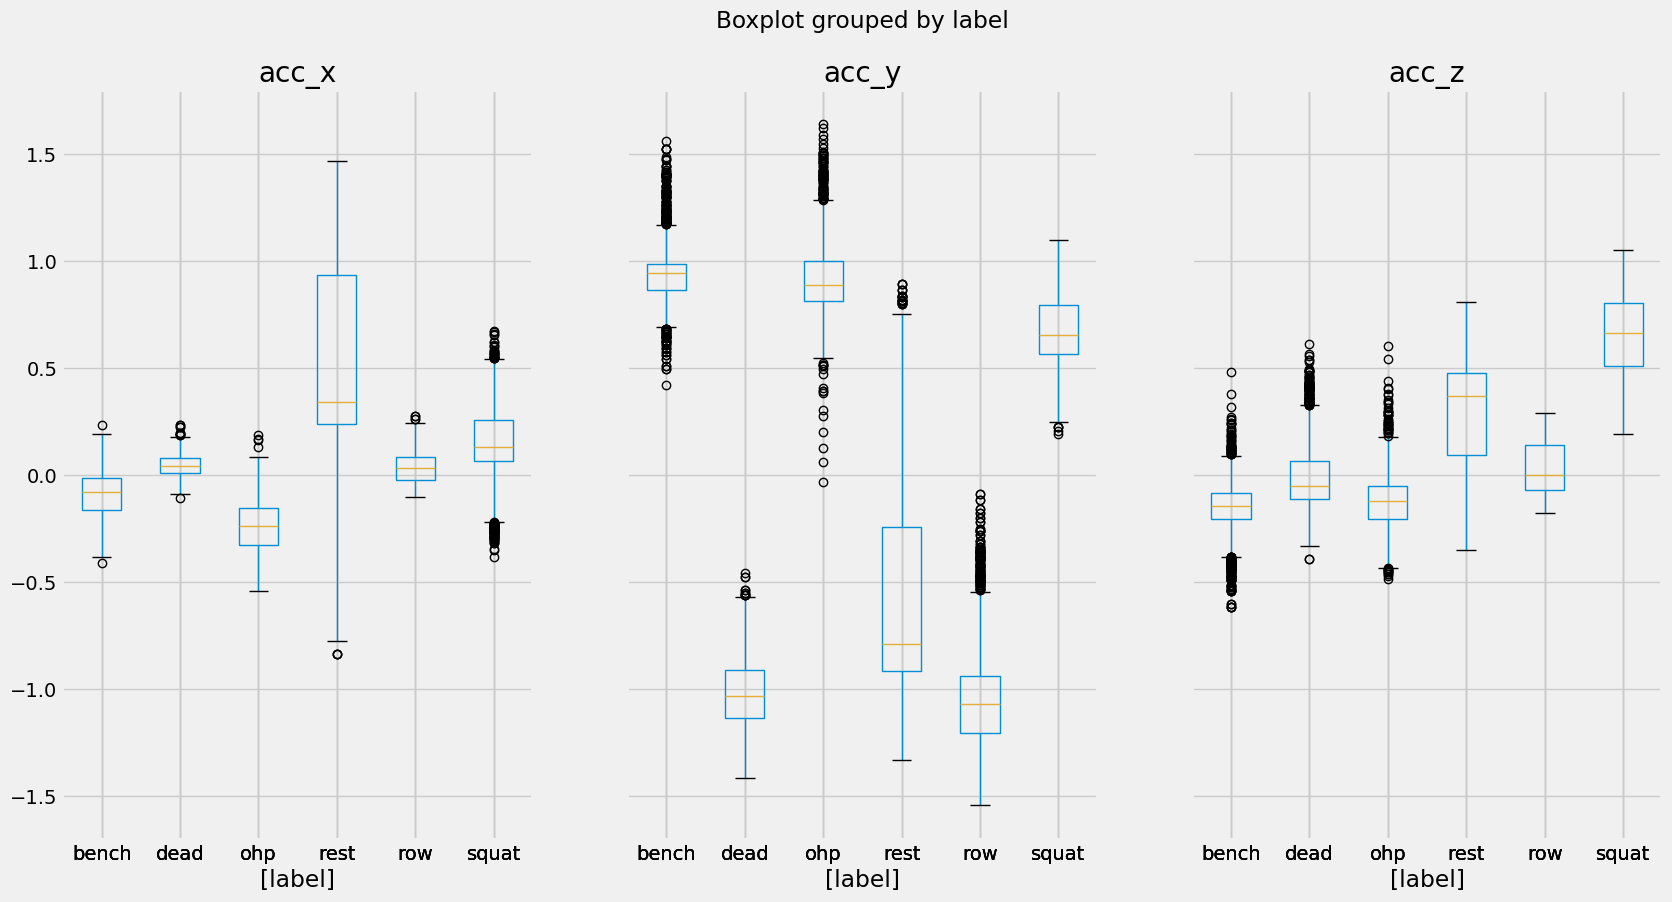

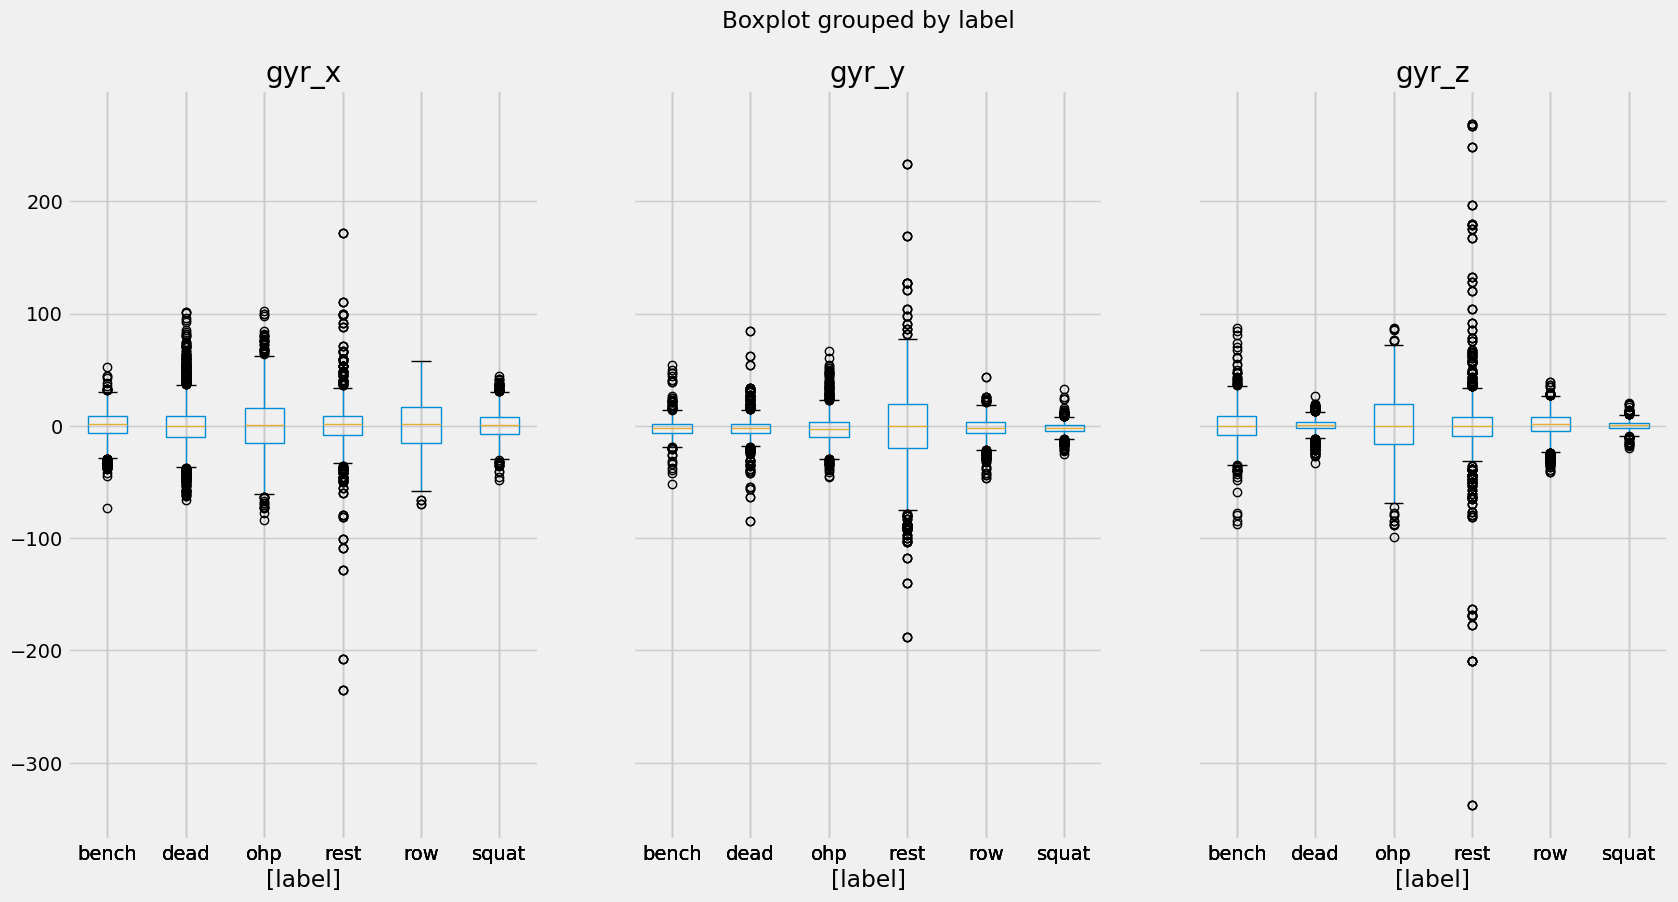

In [7]:
#Plotting outliers
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 100

df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))
df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))
plt.show()

Before handling outliers, let's check the data follows normal distribution by statistical testing

In [49]:
from scipy.stats import shapiro

for label in df["label"].unique():
    for feature in df.columns[0:6]:
        stat, p = shapiro(df[df["label"] == label][feature])
        print(f'Statistic={stat}, p-value={p}')
        if p > 0.05:
            print(f"{label}{feature} is likely normally distributed (fail to reject H0)")
        else:
            print(f"{label}{feature} is not normally distributed (reject H0)")

Statistic=0.9667893138570599, p-value=4.024337987912482e-19
benchacc_x is not normally distributed (reject H0)
Statistic=0.9334929103954136, p-value=1.2849037345396598e-26
benchacc_y is not normally distributed (reject H0)
Statistic=0.9482339892783447, p-value=9.252297154494298e-24
benchacc_z is not normally distributed (reject H0)
Statistic=0.9790412040222414, p-value=6.999584313657826e-15
benchgyr_x is not normally distributed (reject H0)
Statistic=0.9277621385054268, p-value=1.3442356410231142e-27
benchgyr_y is not normally distributed (reject H0)
Statistic=0.9562496124665477, p-value=6.136470497988134e-22
benchgyr_z is not normally distributed (reject H0)
Statistic=0.9878761974462865, p-value=1.224862022807591e-10
ohpacc_x is not normally distributed (reject H0)
Statistic=0.9415244763695969, p-value=3.2966699195201717e-25
ohpacc_y is not normally distributed (reject H0)
Statistic=0.9787822873016095, p-value=4.799363437675266e-15
ohpacc_z is not normally distributed (reject H0)
Stat

The statistical test said that most of the data does not follow normal distribution.
This means we cannot use outlier handling method like Chauvenet's Criterion.
Let's simly use IQR method for outlier handling.

##### IQR

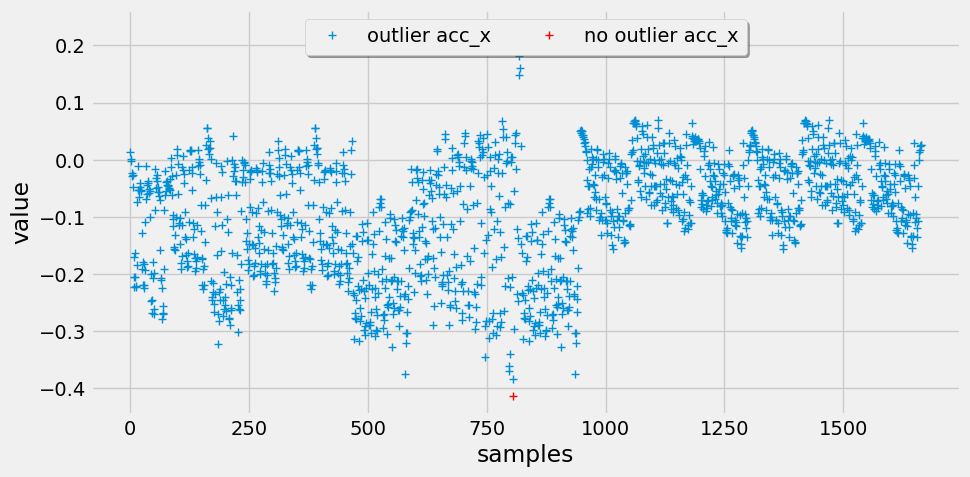

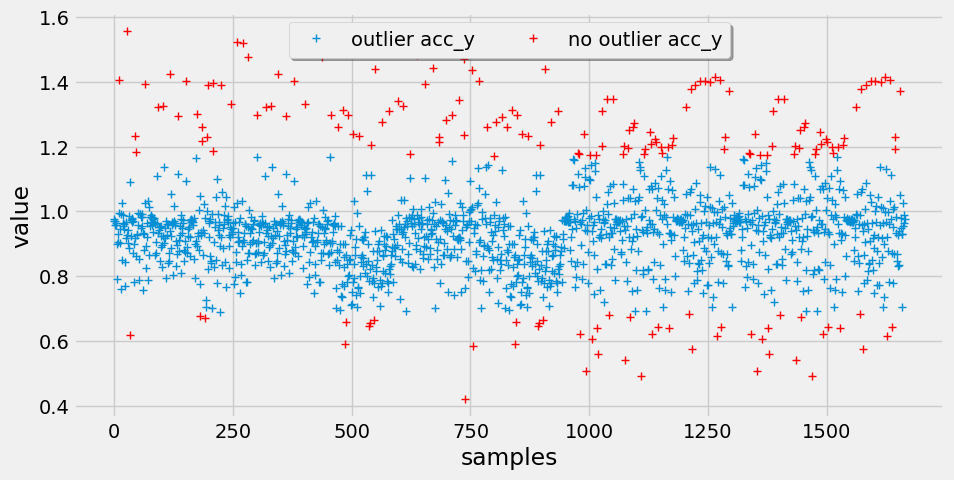

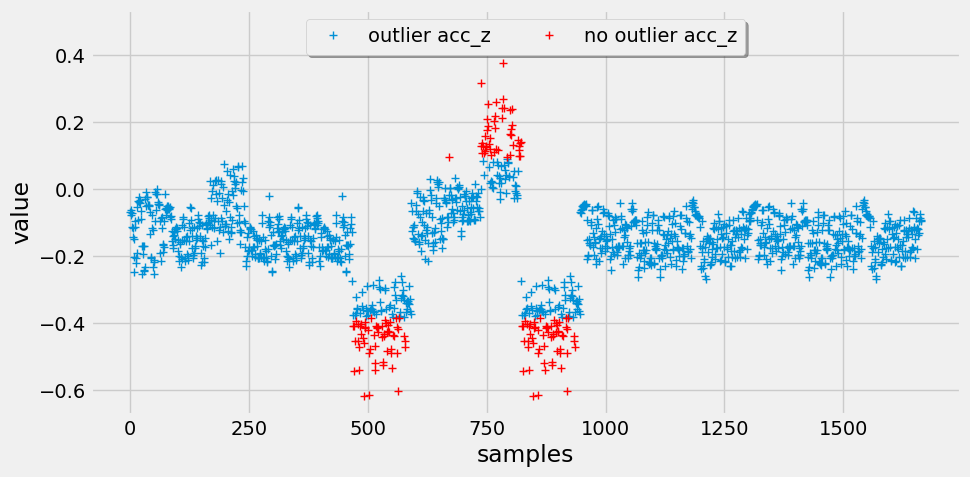

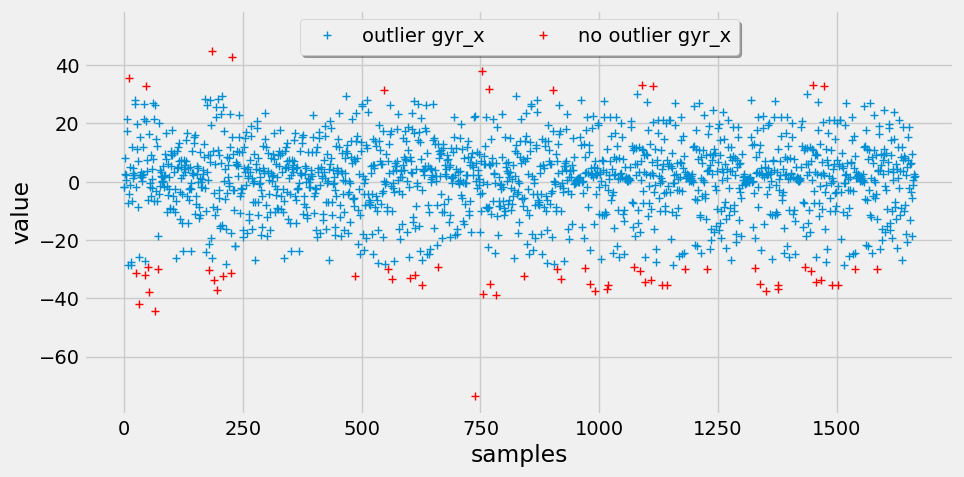

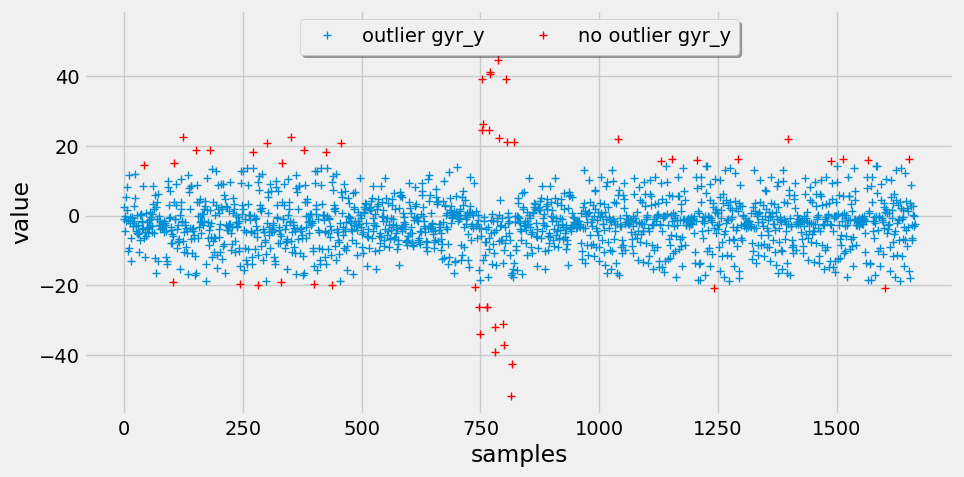

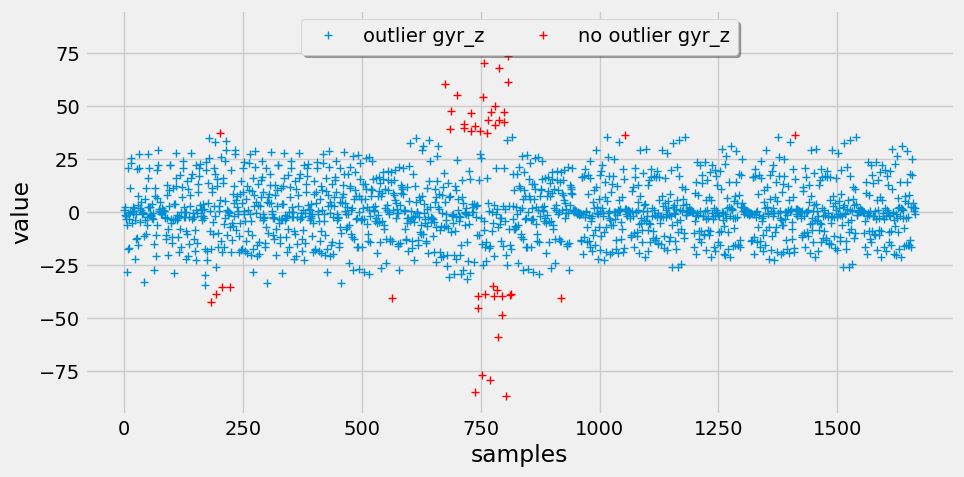

In [40]:
for col in outlier_columns:
    dataset = outlier_detection.mark_outliers_iqr(df[df["label"] == "bench"], col)
    outlier_detection.plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

In [79]:
outliers_removed_df = df.copy()
for col in outlier_columns:
    for label in df["label"].unique():
        dataset = outlier_detection.mark_outliers_iqr(df[df["label"] == label], col)

        dataset.loc[dataset[col + "_outlier"], col] = np.nan

        outliers_removed_df.loc[(outliers_removed_df["label"] == label), col] = dataset[
            col
        ]

        n_outliers = len(dataset) - len(dataset[col].dropna())
        print(f"Removed {n_outliers} from {col} for {label}")

outliers_removed_df.info()

Removed 2 from acc_x for bench
Removed 4 from acc_x for ohp
Removed 105 from acc_x for squat
Removed 11 from acc_x for dead
Removed 4 from acc_x for row
Removed 3 from acc_x for rest
Removed 191 from acc_y for bench
Removed 107 from acc_y for ohp
Removed 5 from acc_y for squat
Removed 11 from acc_y for dead
Removed 142 from acc_y for row
Removed 24 from acc_y for rest
Removed 168 from acc_z for bench
Removed 53 from acc_z for ohp
Removed 0 from acc_z for squat
Removed 104 from acc_z for dead
Removed 0 from acc_z for row
Removed 0 from acc_z for rest
Removed 66 from gyr_x for bench
Removed 44 from gyr_x for ohp
Removed 52 from gyr_x for squat
Removed 240 from gyr_x for dead
Removed 4 from gyr_x for row
Removed 150 from gyr_x for rest
Removed 56 from gyr_y for bench
Removed 86 from gyr_y for ohp
Removed 97 from gyr_y for squat
Removed 121 from gyr_y for dead
Removed 63 from gyr_y for row
Removed 93 from gyr_y for rest
Removed 50 from gyr_z for bench
Removed 16 from gyr_z for ohp
Removed 

In [80]:
outliers_removed_df.to_csv("data/interim/1_outlier_removed")